## IMPORT

In [1]:
import os
import time
import copy
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import clear_output
import concurrent.futures
from types import SimpleNamespace
import concurrent.futures
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

## CLASS

### MAJOR CLASS

In [2]:
class ConnectX:
    # { INITIALIZATION } -------------------------------------------------------------------------
    def __init__(self, inarow, columns = 0, rows = 0, board = None, turn = 1, last_checker = None):
        self.PLAYER1 = 1
        self.PLAYER2 = 2
        self.NONE = 0
        
        self.inarow = inarow
        if board:
            self.columns = len(board[0])
            self.rows = len(board)
            if board != None:
                self.board = copy.deepcopy(board)
            else:
                self.board = [[self.NONE for i in range(self.columns)] for j in range(self.rows)]
            self.turn = turn
            self.last_checker = copy.deepcopy(last_checker) if last_checker is not None else [-1, -1]
        else: 
            self.columns = columns
            self.rows = rows
            self.board = [[self.NONE for i in range(columns)] for j in range(rows)]
            self.turn = self.PLAYER1
            self.last_checker = [-1, -1]    
    def __str__(self):
        def map_value(value):
            if value == 0:
                return ' '
            elif value == 1:
                return 'X'
            elif value == 2:
                return 'O'
            else:
                return str(value)
        return '\n'.join([' '.join(map(map_value, row)) for row in self.board[::-1]])  
    # { BASIC FUNCTIONs } ------------------------------------------------------------------------
    def print(self, mode ='simplified', mark_last_checker = True, mark_winning_positions = False, clear = True, sleep = 1, human_mode = False, winning_positions = []):
        def map_value(value):
            if value == 0:
                return '   '
            elif value == 1:
                return ' X '
            elif value == 2:
                return ' O '
            else:
                return str(value)
        if clear:
            clear_output(wait=True)
        
        display_board = [row[:] for row in self.board]
        
        if mark_winning_positions and winning_positions:
            for row, column in winning_positions:
                if display_board[row][column] == 1:
                    display_board[row][column] = '[X]'
                elif display_board[row][column] == 2:
                    display_board[row][column] = '[O]'

        if mark_last_checker and hasattr(self, 'last_checker') and self.last_checker:
            x, y = self.last_checker
            if display_board[x][y] == 1:
                display_board[x][y] = '[X]'
            elif display_board[x][y] == 2:
                display_board[x][y] = '[O]'
        
        if mode == 'numerical':
            board = '\n'.join([' '.join(map(str, row)) for row in display_board[::-1]])
        elif mode == 'simplified':
            board = '\n'.join([' '.join(map(map_value, row)) for row in display_board[::-1]])
        else:
            board = '\n'.join([' '.join(map(map_value, row)) for row in display_board[::-1]])
            
        if human_mode:
            column_label = ''
            for c in range(self.columns):
                column_label = column_label + '[' + str(c) + '] '
            board = column_label + '\n' + board + '\n' + column_label
        print(board)
        time.sleep(sleep)
    def clear(self):
        self.board = [[self.NONE for i in range(self.columns)] for j in range(self.rows)]
        self.last_checker = [-1, -1]
        self.turn = self.PLAYER1
    def random(self):
        total_drop_checkers = random.randint(0, self.columns * self.rows)
        for i in range(total_drop_checkers):
            self.drop_checker(random.randint(0, self.columns - 1), self.turn)
    # { AGENT MOVEMENTs } ------------------------------------------------------------------------
    def drop_checker(self, column, player = None):
        if player is None:
            player = self.turn
        for i in range(self.rows):
            if self.board[i][column] == 0:
                self.board[i][column] = player
                self.last_checker = [i, column]
                self.turn = self.PLAYER1 if self.turn == self.PLAYER2 else self.PLAYER2
                return i
        
        return -1
    def retrieve_last_checker(self):
        if self.last_checker[0] != -1 and self.last_checker[1] != -1:
            self.board[self.last_checker[0]][self.last_checker[1]] = 0
            self.last_checker = [-1, -1]
            self.turn = self.PLAYER1 if self.turn == self.PLAYER2 else self.PLAYER2
    # { BOARD STATEs } ---------------------------------------------------------------------------
    def pervious_state(self):
        pervious_state = ConnectX(inarow = self.inarow, board = self.board, turn = self.turn, last_checker = self.last_checker)
        pervious_state.retrieve_last_checker()
        return pervious_state     
    def current_state(self, score_calculation_type = 'NONE', verbose = False): 
        current_instance = ConnectX(inarow = self.inarow, board = self.board, turn = self.turn)  
        return self.calculate_instance_scores(current_instance, score_calculation_type, verbose)
    def next_states(self, score_calculation_type = 'NONE', verbose = False):
        next_states = []
        for drop_column in range(self.columns):
            next_instance = ConnectX(inarow = self.inarow, board = self.board, turn = self.turn, last_checker = self.last_checker)
            drop_row = next_instance.drop_checker(drop_column)
            #IGNORE INVALID MOVES
            if drop_row == -1:
                continue
            
            next_state = self.calculate_instance_scores(next_instance, score_calculation_type, verbose)
            next_states.append(next_state)
        if verbose:
            return None
        else:
            return next_states
   # { STATE SPACE SCORE CALCULATION } -----------------------------------------------------------
    def score(self, score_calculation_type = 'NONE'): 
        if score_calculation_type == 'last_checker_longest_connection':
            return self.last_checker_longest_connection()
        elif score_calculation_type == 'last_checker_longest_connection_remove_limited':
            return self.last_checker_longest_connection_remove_limited()
        elif score_calculation_type == 'last_checker_longest_connection_zero_to_infinity':
            return self.last_checker_longest_connection_zero_to_infinity()
        elif score_calculation_type == 'last_checker_all_connections':
            return self.last_checker_all_connections()
        elif score_calculation_type == 'last_checker_all_connections_remove_limited':
            return self.last_checker_all_connections_remove_limited()
        elif score_calculation_type == 'last_checker_all_connections_zero_to_infinity':
            return self.last_checker_all_connections_zero_to_infinity()
        elif score_calculation_type == 'alpha':
            return self.alpha()            
        elif score_calculation_type == 'beta':
            return self.beta()
        elif 'monte_carlo_random' in score_calculation_type:
            if len(score_calculation_type.split('_')) == 4:
                return self.monte_carlo_random(iteration = score_calculation_type.split('_')[3])
            else:
                return self.monte_carlo_random()
        return 0 
    def calculate_instance_scores(self, instance, score_calculation_type, verbose):
        last_checker_longest_connection = float('-inf')
        last_checker_longest_connection_remove_limited = float('-inf')
        last_checker_longest_connection_zero_to_infinity = float('-inf')
        
        last_checker_all_connections = float('-inf')
        last_checker_all_connections_remove_limited = float('-inf')
        last_checker_all_connections_zero_to_infinity = float('-inf')
        
        alpha = float('-inf')
        beta = float('-inf')
        
        monte_carlo_random = float('-inf')
        
        if score_calculation_type == 'last_checker_longest_connection':
            last_checker_longest_connection = instance.last_checker_longest_connection()
        elif score_calculation_type == 'last_checker_longest_connection_remove_limited':
            last_checker_longest_connection_remove_limited = instance.last_checker_longest_connection_remove_limited()
        elif score_calculation_type == 'last_checker_longest_connection_zero_to_infinity':
            last_checker_longest_connection_zero_to_infinity = instance.last_checker_longest_connection_zero_to_infinity()
        
        elif score_calculation_type == 'last_checker_all_connections':
            last_checker_all_connections = instance.last_checker_all_connections()
        elif score_calculation_type == 'last_checker_all_connections_remove_limited':
            last_checker_all_connections_remove_limited = instance.last_checker_all_connections_remove_limited()
        elif score_calculation_type == 'last_checker_all_connections_zero_to_infinity':
            last_checker_all_connections_zero_to_infinity = instance.last_checker_all_connections_zero_to_infinity()
            
        elif score_calculation_type == 'alpha':
            alpha = instance.alpha()
        elif score_calculation_type == 'beta':
            beta = instance.beta()
            
        elif 'monte_carlo_random' in score_calculation_type:
            if len(score_calculation_type.split('_')) == 4:
                return instance.monte_carlo_random(iteration = score_calculation_type.split('_')[3])
            else:
                return instance.monte_carlo_random()
            
        elif score_calculation_type == 'ALL':
            last_checker_longest_connection = instance.last_checker_longest_connection()
            last_checker_longest_connection_remove_limited = instance.last_checker_longest_connection_remove_limited()
            last_checker_longest_connection_zero_to_infinity = instance.last_checker_longest_connection_zero_to_infinity()
            last_checker_all_connections = instance.last_checker_all_connections()
            last_checker_all_connections_remove_limited = instance.last_checker_all_connections_remove_limited()
            last_checker_all_connections_zero_to_infinity = instance.last_checker_all_connections_zero_to_infinity()
            alpha = instance.alpha()
            beta = instance.beta()
            monte_carlo_random = instance.monte_carlo_random()
                
        calculated_instance = SimpleNamespace(
            state_instance = instance,
            
            last_checker_longest_connection = last_checker_longest_connection,
            last_checker_longest_connection_remove_limited = last_checker_longest_connection_remove_limited,
            last_checker_longest_connection_zero_to_infinity = last_checker_longest_connection_zero_to_infinity,
            
            last_checker_all_connections = last_checker_all_connections,
            last_checker_all_connections_remove_limited = last_checker_all_connections_remove_limited,
            last_checker_all_connections_zero_to_infinity = last_checker_all_connections_zero_to_infinity,
            
            alpha = alpha,
            beta = beta,
            
            monte_carlo_random = monte_carlo_random
        )
        if verbose:
            instance.print(clear=False)
            if score_calculation_type == 'last_checker_longest_connection':
                print("LAST CHECKER LONGEST CONNECTION:", last_checker_longest_connection)
            elif score_calculation_type == 'last_checker_longest_connection_remove_limited':
                print("LAST CHECKER LONGEST CONNECTION REMOVE LIMITED:", last_checker_longest_connection_remove_limited)
            elif score_calculation_type == 'last_checker_longest_connection_zero_to_infinity':
                print("LAST CHECKER LONGEST CONNECTION ZERO TO INFINITY:", last_checker_longest_connection_zero_to_infinity)
            elif score_calculation_type == 'last_checker_all_connections':
                print("LAST CHECKER ALL CONNECTIONS:", last_checker_all_connections)
            elif score_calculation_type == 'last_checker_all_connections_remove_limited':
                print("LAST CHECKER ALL CONNECTIONS REMOVE LIMITED:", last_checker_all_connections_remove_limited)
            elif score_calculation_type == 'last_checker_all_connections_zero_to_infinity':
                print("LAST CHECKER ALL CONNECTIONS ZERO TO INFINITY:", last_checker_all_connections_zero_to_infinity)
            elif score_calculation_type == 'alpha':
                print("ALPHA:", alpha)
            elif score_calculation_type == 'beta':
                print("BETA:", beta)
            elif score_calculation_type == 'monte_carlo_random':
                print("MONTE CARLO RANDOM:", monte_carlo_random)
            elif score_calculation_type == 'ALL':
                print("LAST CHECKER LONGEST CONNECTION:", last_checker_longest_connection)
                print("LAST CHECKER LONGEST CONNECTION REMOVE LIMITED:", last_checker_longest_connection_remove_limited)
                print("LAST CHECKER LONGEST CONNECTION ZERO TO INFINITY:", last_checker_longest_connection_zero_to_infinity)
                print("LAST CHECKER ALL CONNECTIONS:", last_checker_all_connections)
                print("LAST CHECKER ALL CONNECTIONS REMOVE LIMITED:", last_checker_all_connections_remove_limited)
                print("LAST CHECKER ALL CONNECTIONS ZERO TO INFINITY:", last_checker_all_connections_zero_to_infinity)
                print("ALPHA:", alpha)
                print("BETA:", beta)
                print("MONTE CARLO RANDOM:", monte_carlo_random)
        return calculated_instance
 
    def last_checker_longest_connection(self):
        def check_count_in_a_row_next_position(row, column, connection, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return connection
            if self.board[row][column] != 3 - self.turn:
                return connection
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, direction)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        longest_connection = 0
        
        for direction in directions:
            connection = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 1, direction)
            connection += check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, [-direction[0], -direction[1]])
            if connection >= longest_connection:
                longest_connection = connection
        return longest_connection
    def last_checker_longest_connection_remove_limited(self):
        def check_count_in_a_row_next_position(row, column, connection, space, connected, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == self.turn:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == 3 - self.turn and connected:
                return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, space + 1, True, direction)
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection, space + 1, False, direction)
        
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        longest_connection = 0
        
        for direction in directions:
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 1, 1, True, direction)
            connection = count_connection_and_space['connection']
            space = count_connection_and_space['space']
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, 0, True, [-direction[0], -direction[1]])
            connection += count_connection_and_space['connection']
            space += count_connection_and_space['space']
            
            if space < self.inarow:
                connection = 0
            if connection >= longest_connection:
                longest_connection = connection
        return longest_connection
    def last_checker_longest_connection_zero_to_infinity(self):
        def check_count_in_a_row_next_position(row, column, connection, space, connected, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == self.turn:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == 3 - self.turn and connected:
                return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, space + 1, True, direction)
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection, space + 1, False, direction)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        longest_connection = 0
        
        for direction in directions:
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 1, 1, True, direction)
            connection = count_connection_and_space['connection']
            space = count_connection_and_space['space']
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, 0, True, [-direction[0], -direction[1]])
            connection += count_connection_and_space['connection']
            space += count_connection_and_space['space']
            
            if space < self.inarow:
                connection = 0
            if connection >= self.inarow:
                connection = float('inf')
                return connection
            if connection >= longest_connection:
                longest_connection = connection
        return longest_connection
    def last_checker_inarow_connection(self):
        def deep_copy_2d_array(array):
            return [[array[i][j] for j in range(len(array[0]))] for i in range(len(array))]
        def check_count_in_a_row_next_position(inarow, row, column, connection_length, direction, inarow_positions):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return connection_length
            if self.board[row][column] != 3 - self.turn:
                return connection_length
            if connection_length >= inarow:
                return connection_length
            inarow_positions.append([row, column])
            return check_count_in_a_row_next_position(inarow, row + direction[0], column + direction[1], connection_length + 1, direction, inarow_positions)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        longest_connection = 0
        longest_inarow_positions = []
        
        for direction in directions:
            connection = 1
            inarow_positions = [[self.last_checker[0], self.last_checker[1]]]
            connection = check_count_in_a_row_next_position(self.inarow, self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], connection, direction, inarow_positions)
            connection = check_count_in_a_row_next_position(self.inarow, self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], connection, [-direction[0], -direction[1]], inarow_positions)
            
            if connection >= longest_connection:
                longest_connection = connection
                longest_inarow_positions = deep_copy_2d_array(inarow_positions)
                
        return longest_inarow_positions
    
    def last_checker_all_connections(self):
        def check_count_in_a_row_next_position(row, column, connection, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return connection
            if self.board[row][column] != 3 - self.turn:
                return connection
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, direction)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        all_connection = 1
        
        for direction in directions:
            connection = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 0, direction)
            connection += check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, [-direction[0], -direction[1]])
            all_connection += connection
        return all_connection
    def last_checker_all_connections_remove_limited(self):
        def check_count_in_a_row_next_position(row, column, connection, space, connected, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == self.turn:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == 3 - self.turn and connected:
                return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, space + 1, True, direction)
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection, space + 1, False, direction)
        
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        all_connection = 1
        
        for direction in directions:
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 0, 1, True, direction)
            connection = count_connection_and_space['connection']
            space = count_connection_and_space['space']
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, 0, True, [-direction[0], -direction[1]])
            connection += count_connection_and_space['connection']
            space += count_connection_and_space['space']
            
            if space < self.inarow:
                connection = 0
            all_connection += connection
        return all_connection
    def last_checker_all_connections_zero_to_infinity(self):
        def check_count_in_a_row_next_position(row, column, connection, space, connected, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == self.turn:
                return {'connection': connection, 'space': space}
            if self.board[row][column] == 3 - self.turn and connected:
                return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, space + 1, True, direction)
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection, space + 1, False, direction)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        all_connection = 1
        
        for direction in directions:
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 0, 1, True, direction)
            connection = count_connection_and_space['connection']
            space = count_connection_and_space['space']
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, 0, True, [-direction[0], -direction[1]])
            connection += count_connection_and_space['connection']
            space += count_connection_and_space['space']
            
            if space < self.inarow:
                connection = 0
            if connection >= self.inarow-1:
                connection = float('inf')
                return connection
            all_connection += connection
        return all_connection
    
    def alpha(self):
        def check_count_in_a_row_next_position(row, column, connection, space, isolated_checker, droppable, connected, direction):
            if row < 0 or row >= self.rows or column < 0 or column >= self.columns:
                return {'connection': connection, 'space': space, 'isolated_checker': isolated_checker, 'droppable': droppable}
            if self.board[row][column] == self.turn:
                return {'connection': connection, 'space': space, 'isolated_checker': isolated_checker, 'droppable': droppable}
            if self.board[row][column] == 3 - self.turn and connected:
                return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection + 1, space, isolated_checker, droppable, True, direction)
            if self.board[row][column] == 3 - self.turn and not connected:
                isolated_checker += round(1.0 / (space + 1.0), 2)
            if space == 0 and (row - 1 < 0 or self.board[row - 1][column] != 0):
                droppable = True
            return check_count_in_a_row_next_position(row + direction[0], column + direction[1], connection, space + 1, isolated_checker, droppable, False, direction)
        
        directions = [[0,1], [1,0], [1,1], [1,-1]]
        all_connection = 1
        
        for direction in directions:
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] + direction[0], self.last_checker[1] + direction[1], 0, 0, 0, False, True, direction)
            forward_connection = count_connection_and_space['connection']
            forward_space = count_connection_and_space['space']
            isolated_checker = count_connection_and_space['isolated_checker']
            foward_droppable = count_connection_and_space['droppable']
            
            count_connection_and_space = check_count_in_a_row_next_position(self.last_checker[0] - direction[0], self.last_checker[1] - direction[1], 0, 0, 0, False, True, [-direction[0], -direction[1]])
            backward_connection = count_connection_and_space['connection']
            backward_space = count_connection_and_space['space']
            isolated_checker += count_connection_and_space['isolated_checker']
            backward_droppable = count_connection_and_space['droppable']
            
            connection = 0.0 + forward_connection + backward_connection + isolated_checker
            space = forward_space + backward_space
            
            if connection >= self.inarow - 1:
                all_connection = float('inf')
                return all_connection
            if connection >= self.inarow - 2 and foward_droppable and backward_droppable:
                all_connection = float('inf')
                return all_connection
                        
            if space + connection < self.inarow - 1:
                connection = 0
            
            all_connection += connection
        return all_connection  
    def beta(self): # [0] WIN LOWER BOUND [1] WIN PROBABILITY [2] WIN UPPER BOUND [3] LOST LOWER BOUND [4] LOST PROBABILITY [5] LOST UPPER BOUND
        def beta_monte_carlo_random(state_instance, iteration = 385):
            agent_pool = ['RANDOM']
            total_games = iteration
            win_and_lost_prob = [0.0, 0.0]
            
            current_instance = ConnectX(inarow = state_instance.inarow, board = state_instance.board, turn = state_instance.turn, last_checker= state_instance.last_checker)
            
            # If current move leads us to win the game, then we should make that move by setting score to 100 --------------------------------------------------------
            if current_instance.last_checker_longest_connection() >= current_instance.inarow:
                win_and_lost_prob = [100.0, 0.0]
                return win_and_lost_prob
            next_states = current_instance.next_states()
            
            # If after current move, there's a move that can leads to our opponent winning, then we should avoid that move by setting score to -100 ------------------
            for next_state in next_states:
                if next_state.state_instance.last_checker_longest_connection() >= current_instance.inarow:
                    win_and_lost_prob = [0.0, 100.0]
                    return win_and_lost_prob
            
            agent_1 = Agent(random.choice(agent_pool)) # type: ignore
            agent_2 = Agent(random.choice(agent_pool)) # type: ignore
            match_result = current_instance.multiple_games(agent_1, agent_2, total_games = total_games, new_game = False, verbose = False)
            win_and_lost_prob = [match_result[3 - state_instance.turn] / total_games * 100.0 * 1.0, match_result[state_instance.turn] / total_games * 100.0 * 1.0]
                    
            return win_and_lost_prob   
        def calConfidenceInterval(probability, sample_size):
            p = probability
            n = sample_size
            z = 1.96

            interval = z * math.sqrt(p * (1 - p) / n)
            lower_bound = p - interval
            upper_bound = p + interval

            return [lower_bound, upper_bound]
        def isAfterMiddle(state_instance):
            zero_count = 0
            for row in state_instance.board:
                zero_count += row.count(0)
            return zero_count < state_instance.columns * state_instance.rows / 2
        
        iteration = 385
        
        win_and_lost_prob = beta_monte_carlo_random(self)
        beta_win = win_and_lost_prob[0] / 100.0
        # beta_lost = win_and_lost_prob[1] / 100.0
        # win_lower_bound, win_upper_bound = calConfidenceInterval(beta_win, iteration)
        # lost_lower_bound, lost_upper_bound = calConfidenceInterval(beta_lost, iteration)
        
        # beta = [win_lower_bound, beta_win, win_upper_bound, lost_lower_bound, beta_lost, lost_upper_bound]
        
        return beta_win

    def monte_carlo_random(self, iteration = 385):
        agent_pool = ['RANDOM']
        total_games = iteration
        score = 0
        
        current_instance = ConnectX(inarow = self.inarow, board = self.board, turn = self.turn, last_checker= self.last_checker)
        
        # If current move leads us to win the game, then we should make that move by setting score to 100 --------------------------------------------------------
        if current_instance.last_checker_longest_connection() >= current_instance.inarow:
            score = 100.0
            return score
        next_states = current_instance.next_states()
        
        # If after current move, there's a move that can leads to our opponent winning, then we should avoid that move by setting score to -100 ------------------
        for next_state in next_states:
            if next_state.state_instance.last_checker_longest_connection() >= current_instance.inarow:
                score = -100.0
                return score
        
        agent_1 = Agent(random.choice(agent_pool)) # type: ignore
        agent_2 = Agent(random.choice(agent_pool)) # type: ignore
        match_result = current_instance.multiple_games(agent_1, agent_2, total_games = total_games, new_game = False, verbose = False)
        score += match_result[3 - self.turn] / total_games * 100.0 * 1.0
        score -= match_result[self.turn] / total_games * 100.0 * 1.0
                
        return score         
    # { GAME } -----------------------------------------------------------------------------------
    def game(self, agent_1, agent_2, echo_options = 'EACH_MOVE', new_game = True): # [ECHO_OPTIONS: 'EACH_MOVE | sleep_second', 'EACH_EPISODE', 'NONE'] 
        def count_checkers():
            checkers = 0
            for r in range(self.rows):
                for c in range(self.columns):
                    if self.board[r][c] != 0:
                        checkers += 1
            return checkers
        human_mode = False
        if agent_1.type == 'HUMAN' or agent_2.type == 'HUMAN':
            human_mode = True

        if new_game:
            self.clear()
            checker_dropped = 0
        else:
            checker_dropped = count_checkers()
        configuration = SimpleNamespace(
            columns = self.columns,
            rows = self.rows,
            inarow = self.inarow
        )
        while True:
            # DRAW CHECKER --------------------------------------------------------------
            if checker_dropped >= self.rows * self.columns:
                if echo_options == 'EACH_EPISODE':
                    self.print(human_mode = human_mode)
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    print("[DRAW THE GAME]")
                if echo_options == 'NONE':
                    return 0
                break
            # DRAW CHECKER --------------------------------------------------------------
            
            observation = SimpleNamespace(
                board = self.board,
                mark = self.turn
            )
            
            # PLAYER DROP CHECKER ======================================================= 
            if self.turn == self.PLAYER1:
                drop_column = agent_1.move(observation, configuration)
            else:
                drop_column = agent_2.move(observation, configuration)  
            # PLAYER DROP CHECKER ======================================================= 
            
            # LOST DUE TO PLAYER MADE INVALID MOVE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
            if drop_column == -1:
                if echo_options == 'EACH_EPISODE':
                    self.print(human_mode = human_mode)
                if echo_options == 'EACH_EPISODE' or echo_options == 'EACH_MOVE':
                    print("[PLAYER", self.turn, "LOST THE GAME]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break   
            # LOST DUE TO PLAYER MADE INVALID MOVE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
            drop_row = self.drop_checker(drop_column, self.turn)
            
            # PRINT BOARD ----------------------------------------------------------------
            if 'EACH_MOVE' in echo_options:
                if len(echo_options.split(' | ')) > 1:
                    self.print(sleep = int(echo_options.split(' | ')[1]), human_mode = human_mode)
                else:
                    self.print(human_mode = human_mode)
            # PRINT BOARD ----------------------------------------------------------------
            
            if drop_row == -1:
                if echo_options == 'EACH_EPISODE':
                    self.print(human_mode = human_mode)
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    print("[PLAYER", self.turn, "LOST THE GAME]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break
            checker_dropped += 1
            # CHECK WINNER ---------------------------------------------------------------
            if self.last_checker_longest_connection() >= self.inarow:
                if echo_options == 'EACH_EPISODE':
                    self.print(human_mode = human_mode)
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    self.print(human_mode = human_mode, mark_winning_positions=True, winning_positions = self.last_checker_inarow_connection())
                    print("[PLAYER", 3 - self.turn, "WON THE GAME]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break
            # CHECK WINNER ---------------------------------------------------------------
    def multiple_games(self, agent_1, agent_2, total_games = 100, new_game = True, verbose = True, switch_first_hand = True):
        def render_progress_bar(game, total_games, last_progress_update):
            percent = (game / total_games)
            if int(percent * 100) != last_progress_update:
                progress = int(50 * percent)
                bar = "#" * progress + "-" * (50 - progress)
                clear_output(wait=True)
                print(f'[{bar}] {percent:.2%}')
                time.sleep(0.02)
                return int(percent * 100)
            return last_progress_update
        results = {1: 0, 2: 0, 0: 0}
        last_progress_update = 0
        for i in range(total_games):
            clone_instance = ConnectX(inarow = self.inarow, board = self.board, turn = self.turn)
            if switch_first_hand:
                if i % 2 == 0:
                    result = clone_instance.game(agent_1, agent_2, echo_options='NONE', new_game = new_game)
                    results[result] += 1
                else:
                    result = clone_instance.game(agent_2, agent_1, echo_options='NONE', new_game = new_game)
                    if result == 0:
                        results[0] += 1
                    else:
                        results[3 - result] += 1
            else:
                result = clone_instance.game(agent_1, agent_2, echo_options='NONE', new_game = new_game)
                results[result] += 1
            if verbose:
                last_progress_update = render_progress_bar(i + 1, total_games, last_progress_update)
        if verbose:
            print("[ " + agent_1.type + " WINS:", round(results[1]/total_games, 2) * 100, "% " + agent_2.type + " WINS:", round(results[2]/total_games, 2) * 100, "% DRAWS:", round(results[0]/total_games, 2) * 100, '% ]')
            time.sleep(1)
        return results
    def record(self, agent_1, agent_2, echo_options = 'EACH_MOVE', batch_size=32, min_replay_memory_size=512, recording_reinforcement_agent=None):
        def pervious_oppo_state(pervious_state, oppo_last_checker):
            pervious_2_state = ConnectX(inarow = pervious_state.inarow, board = pervious_state.board, turn = pervious_state.turn, last_checker = pervious_state.last_checker)

            if oppo_last_checker[0] != -1 and oppo_last_checker[1] != -1:
                pervious_2_state.board[oppo_last_checker[0]][oppo_last_checker[1]] = 0
                pervious_2_state.last_checker = [-1, -1]
                pervious_2_state.turn = pervious_2_state.PLAYER1 if pervious_2_state.turn == pervious_2_state.PLAYER2 else pervious_2_state.PLAYER2
            return pervious_2_state
        
        # CHECK WHICH AGENT IS REINFORCEMENT LEARNING AGENT
        reinforcement_learning_agent = []
        if agent_1.type == "REINFORCEMENT":
            reinforcement_learning_agent.append(1)
        if agent_2.type == "REINFORCEMENT":
            reinforcement_learning_agent.append(2)
        if recording_reinforcement_agent is not None and recording_reinforcement_agent.type == "REINFORCEMENT":
            reinforcement_learning_agent.append(3)
        if len(reinforcement_learning_agent) == 0:
            print('ERROR: NO REINFORCEMENT LEARNING AGENT, PLEASE SELECT AT LEAST ONE REINFORCEMENT LEARNING AGENT')
            return None
    
        oppo_last_checker = [-1, -1]
    
        self.clear()
        checker_dropped = 0
        configuration = SimpleNamespace(
            columns = self.columns,
            rows = self.rows,
            inarow = self.inarow
        )
        while True:
            observation = SimpleNamespace(
                board = self.board,
                mark = self.turn
            )
            
            # PLAYER DROP CHECKER ======================================================= 
            if self.turn == self.PLAYER1:
                drop_column = agent_1.move(observation, configuration)
            else:
                drop_column = agent_2.move(observation, configuration)  
            # PLAYER DROP CHECKER ======================================================= 
            
            # LOST DUE TO PLAYER MADE INVALID MOVE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
            if drop_column == -1:
                if self.turn == self.PLAYER1:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, self.board, -1, -1, self.board, True)
                        recording_reinforcement_agent.remember(2, self.pervious_state().board, oppo_last_checker[1], 1, self.board, True)
                    else:
                        agent_1.remember(1, self.board, -1, -1, self.board, True)
                        agent_2.remember(2, self.pervious_state().board, oppo_last_checker[1], 1, self.board, True)
                        
                else:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, self.pervious_state().board, oppo_last_checker[1], 1, self.board, True)
                        recording_reinforcement_agent.remember(2, self.board, -1, -1, self.board, True)
                    else:
                        agent_1.remember(1, self.pervious_state().board, oppo_last_checker[1], 1, self.board, True)
                        agent_2.remember(2, self.board, -1, -1, self.board, True)
                    
                if echo_options == 'EACH_EPISODE':
                    self.print()
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    self.print(mark_winning_positions=True, winning_positions = self.last_checker_inarow_connection())
                    print("[PLAYER", self.turn, "MADE A INVALID MOVE]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break
            # LOST DUE TO PLAYER MADE INVALID MOVE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 
            
            drop_row = self.drop_checker(drop_column, self.turn)
            
            # PRINT BOARD ----------------------------------------------------------------
            if 'EACH_MOVE' in echo_options:
                if len(echo_options.split(' | ')) > 1:
                    self.print(sleep = int(echo_options.split(' | ')[1]))
                else:
                    self.print()
            # PRINT BOARD ----------------------------------------------------------------
            
            if drop_row == -1:
                if self.turn == self.PLAYER1:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, self.board, drop_column, -1, self.board, True)
                        recording_reinforcement_agent.remember(2, self.pervious_state().board, oppo_last_checker[1], 0, self.board, True)
                    else:
                        agent_1.remember(1, self.board, drop_column, -1, self.board, True)
                        agent_2.remember(2, self.pervious_state().board, oppo_last_checker[1], 0, self.board, True)
                else:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, self.pervious_state().board, oppo_last_checker[1], 0, self.board, True)
                        recording_reinforcement_agent.remember(2, self.board, drop_column, -1, self.board, True)
                    else:
                        agent_1.remember(1, self.pervious_state().board, oppo_last_checker[1], 0, self.board, True)
                        agent_2.remember(2, self.board, drop_column, -1, self.board, True)      
                
                if echo_options == 'EACH_EPISODE':
                    self.print()
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    self.print(mark_winning_positions=True, winning_positions = self.last_checker_inarow_connection())
                    print("[PLAYER", self.turn, "MADE A INVALID MOVE]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break
            
            checker_dropped += 1
            
            # CHECK WINNER ---------------------------------------------------------------
            if self.last_checker_longest_connection() >= self.inarow:
                pervious_state = self.pervious_state()
                pervious_2_state = pervious_oppo_state(pervious_state, oppo_last_checker)
                
                if (3 - self.turn) == self.PLAYER1:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, pervious_state.board, drop_column, 1, self.board, True)
                        recording_reinforcement_agent.remember(2, pervious_2_state.board, oppo_last_checker[1], -1, pervious_state.board, True)
                    else:
                        agent_1.remember(1, pervious_state.board, drop_column, 1, self.board, True)
                        agent_2.remember(2, pervious_2_state.board, oppo_last_checker[1], -1, pervious_state.board, True)
                else:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, pervious_2_state.board, oppo_last_checker[1], -1, pervious_state.board, True)
                        recording_reinforcement_agent.remember(2, pervious_state.board, drop_column, 1, self.board, True)
                    else:    
                        agent_1.remember(1, pervious_2_state.board, oppo_last_checker[1], -1, pervious_state.board, True)
                        agent_2.remember(2, pervious_state.board, drop_column, 1, self.board, True)
                        
                if echo_options == 'EACH_EPISODE':
                    self.print()
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    self.print(mark_winning_positions=True, winning_positions = self.last_checker_inarow_connection())
                    print("[PLAYER", 3 - self.turn, "WON THE GAME]")
                if echo_options == 'NONE':
                    return 3 - self.turn
                break
            # CHECK WINNER ---------------------------------------------------------------
            
            # DRAW CHECKER ---------------------------------------------------------------
            if checker_dropped >= self.rows * self.columns:
                pervious_state = self.pervious_state()
                pervious_2_state = pervious_oppo_state(pervious_state, oppo_last_checker)
                
                if (3 - self.turn) == self.PLAYER1:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, pervious_state.board, drop_column, 0, self.board, True)
                        recording_reinforcement_agent.remember(2, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, True)
                    else:
                        agent_1.remember(1, pervious_state.board, drop_column, 0, self.board, True)
                        agent_2.remember(2, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, True)
                else:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, True)
                        recording_reinforcement_agent.remember(2, pervious_state.board, drop_column, 0, self.board, True)
                    else:
                        agent_1.remember(1, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, True)
                        agent_2.remember(2, pervious_state.board, drop_column, 0, self.board, True)
                
                if echo_options == 'EACH_EPISODE':
                    self.print()
                if echo_options == 'EACH_EPISODE' or 'EACH_MOVE' in echo_options:
                    print("[DRAW THE GAME]")
                if echo_options == 'NONE':
                    return 0
                break
            # DRAW CHECKER ---------------------------------------------------------------
            
            # NETURE APPEND MEMORY -------------------------------------------------------
            if oppo_last_checker[0] != -1 and oppo_last_checker[1] != -1:
                pervious_state = self.pervious_state()
                pervious_2_state = pervious_oppo_state(pervious_state, oppo_last_checker)
                if (3 - self.turn) == self.PLAYER1:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(2, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, False)
                    else:
                        agent_2.remember(2, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, False)
                else:
                    if recording_reinforcement_agent is not None:
                        recording_reinforcement_agent.remember(1, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, False)
                    else:
                        agent_1.remember(1, pervious_2_state.board, oppo_last_checker[1], 0, pervious_state.board, False)
            oppo_last_checker = [drop_row, drop_column]
            # NETURE APPEND MEMORY -------------------------------------------------------

    def multiple_records(self, agent_1, agent_2, total_records = 1028, verbose = True,  switch_first_hand = True, recording_reinforcement_agent=None):
        def render_progress_bar(game, total_games, last_progress_update):
            percent = (game / total_games)
            if int(percent * 100) != last_progress_update:
                progress = int(50 * percent)
                bar = "#" * progress + "-" * (50 - progress)
                clear_output(wait=True)
                print(f'[{bar}] {percent:.2%}')
                time.sleep(0.02)
                return int(percent * 100)
            return last_progress_update
        last_progress_update = 0
        for e in range(total_records):
            if switch_first_hand:
                if e % 2 == 0:
                    self.record(agent_1, agent_2, echo_options='NONE', recording_reinforcement_agent=recording_reinforcement_agent)
                else:
                    self.record(agent_2, agent_1, echo_options='NONE', recording_reinforcement_agent=recording_reinforcement_agent)
            else:
                self.record(agent_1, agent_2, echo_options='NONE', recording_reinforcement_agent=recording_reinforcement_agent)
            if verbose:
                last_progress_update = render_progress_bar(e + 1, total_records, last_progress_update)
    # { HIGH LEVEL FUNCTIONS } -------------------------------------------------------------------
    def why_last_move_is_made(self):
        pervious_state = self.pervious_state()
        pervious_state.next_states(score_calculation_type = 'ALL', verbose = True)

### AGENT CLASS

In [3]:
class Agent:
    def __init__(self, type, config = None):
        self.type = type
        
        if self.type == 'REINFORCEMENT':
            self.losses = []
            self.winning_rates = [[],[],[]]
            if config is None:
                print('ERROR: REINFORCEMENT AGENT NEED CONFIGURATION')
                return None
            if 'columns' in config:
                self.columns = config['columns']
            else:
                self.columns = 7
            if 'rows' in config:
                self.rows = config['rows']
            else:
                self.rows = 6
            if 'inarow' in config:
                self.inarow = config['inarow']
            else:
                self.inarow = 4
            self.state_size = self.columns * self.rows
            self.action_size = self.columns
            self.bytes_per_object = self.columns * self.rows * 4 * 2 + 28 + 4 + 28 + 88
            if 'max_memory_size' in config:
                self.max_memory_size = config['max_memory_size']
            else:
                self.max_memory_size = 1
            self.memory = deque(maxlen=int(self.max_memory_size * 1_073_741_824 / self.bytes_per_object))
            self.gamma = 0.95  # discount rate
            self.epsilon = 1.0  # exploration rate
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.995
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            self.model = self.createDQN(self.rows, self.columns, self.action_size, self.device)
            if 'learning_rate' in config:
                self.learning_rate = config['learning_rate']
            else:
                self.learning_rate = 0.0008
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
            if 'model_path' in config:
                self.model_path = config['model_path']
                checkpoint = torch.load(self.model_path, map_location=self.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            else:
                self.model_path = None
    def move(self, observation, configuration): 
        if self.type == 'HUMAN':
            return self.move_human(observation, configuration)
        elif self.type == 'RANDOM':
            return self.move_random(observation, configuration)
        elif self.type == 'SAVK_MINMAX':
            def board_2d_to_flat(board_2d):
                board_2d_original = board_2d[::-1]
                flat_board = [cell for row in board_2d_original for cell in row]
                return board_2d_original
            original_flat_board = board_2d_to_flat(observation.board)
            converted_observation = SimpleNamespace(
                board = original_flat_board,
                mark = observation.mark
            )
            return self.move_savk_minmax(converted_observation, configuration)
        elif self.type == 'MINMAX_MONTE_CARLO':
            return self.move_minmax_monte_carlo(observation, configuration)
        elif self.type == 'AGGRESSIVE_MONTE_CARLO':
            return self.move_greedy(observation, configuration, score_calculation_type = 'beta')
        elif self.type == 'REINFORCEMENT':
            return self.move_reinforcement_learning(observation, configuration)
        elif 'GREEDY' in self.type:
            greedy_type = self.type.split(' | ')
            if len(greedy_type) == 1:
                return self.move_greedy(observation, configuration)
            else:
                return self.move_greedy(observation, configuration, score_calculation_type = greedy_type[1])
        elif 'MINMAX' in self.type:
            minmax_type = self.type.split(' | ')
            if len(minmax_type) == 1:
                return self.move_minmax(observation, configuration)
            elif len(minmax_type) == 2:
                if minmax_type[1].isnumeric():
                    return self.move_minmax(observation, configuration, depth = int(minmax_type[1]))
                else:
                    return self.move_minmax(observation, configuration, score_calculation_type = minmax_type[1])
            elif len(minmax_type) == 3:
                if minmax_type[1].isnumeric():
                    return self.move_minmax(observation, configuration, depth = int(minmax_type[1]), score_calculation_type = minmax_type[2])
                else:
                    return self.move_minmax(observation, configuration, depth = int(minmax_type[2]), score_calculation_type = minmax_type[1])
            else:
                return self.move_minmax(observation, configuration)
        elif 'MONTE_CARLO' in self.type:
            monte_carlo_type = self.type.split(' | ')
            if len(monte_carlo_type) == 1:
                return self.move_greedy(observation, configuration, score_calculation_type = 'beta')
            elif len(monte_carlo_type) == 2:
                return self.move_monte_carlo(observation, configuration, iteration = int(monte_carlo_type[1]))
            else:
                return self.move_greedy(observation, configuration, score_calculation_type = 'beta')
        else:
            return self.move_random(observation, configuration)
    def config(self):
        if self.type == 'REINFORCEMENT':
            return {
                'columns': self.columns,
                'rows': self.rows,
                'max_memory_size': self.max_memory_size,
                'learning_rate': self.learning_rate,
                'model_path': self.model_path
            }
    # { REINFORCEMENT LEARNING AGENT FUNCTIONs } ------------------------------------------------------------------------------------------
    def createDQN(self, board_rows, board_cols, output_dim, device):
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
                self.bn1 = nn.BatchNorm2d(in_channels)
                self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
                self.bn2 = nn.BatchNorm2d(in_channels)
            def forward(self, x):
                residual = x
                out = F.relu(self.bn1(self.conv1(x)))
                out = self.bn2(self.conv2(out))
                out += residual
                return F.relu(out)
        class DQN(nn.Module):
            def __init__(self):
                super(DQN, self).__init__()
                self.board_rows = board_rows
                self.board_cols = board_cols
                self.output_dim = output_dim
                self.device = device
                
                # Assuming the input would be reshaped into a single-channel image-like format
                self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)  # Single-channel input
                self.bn1 = nn.BatchNorm2d(64)
                self.resblock1 = ResidualBlock(64)
                self.resblock2 = ResidualBlock(64)
                # Flatten the output of the last convolutional layer to feed into a fully connected layer
                self.fc1 = nn.Linear(64 * board_rows * board_cols, 256)
                self.fc2 = nn.Linear(256, output_dim)
            
                self.to(device)
            def forward(self, x):
                # Reshape flat input into (N, C, H, W) format for convolutional layers
                x = x.view(-1, 1, self.board_rows, self.board_cols)  # N examples, 1 channel, Height, Width
                x = F.relu(self.bn1(self.conv1(x)))
                x = self.resblock1(x)
                x = self.resblock2(x)
                x = x.view(x.size(0), -1)  # Flatten
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x
        return DQN()
    
    def remember(self, turn, board, action, reward, next_board, done):
        def encode_board_to_state(board, turn):
            board_array = np.array(board)
            if turn == 2:
                board_array = np.where(board_array == 1, 3, board_array)
                board_array = np.where(board_array == 2, 1, board_array)
                board_array = np.where(board_array == 3, 2, board_array)
            flat_board = board_array.flatten()
            return flat_board
        if self.type != 'REINFORCEMENT':
            return None
        
        state = torch.tensor(encode_board_to_state(board, turn), dtype=torch.float32)
        next_state = torch.tensor(encode_board_to_state(next_board, turn), dtype=torch.float32)
    
        state = state.to(self.device)
        next_state = next_state.to(self.device)
        
        self.memory.append((state, action, reward, next_state, done))
    def replay(self, batch_size):
        if self.type != 'REINFORCEMENT':
            return None
        if len(self.memory) < batch_size:
            print("[WARNING] NO EMPTY MEMORY TO REPLAY")
            return None

        minibatch = random.sample(self.memory, batch_size)
        total_loss = 0

        for state, action, reward, next_state, done in minibatch:
            current_qs = self.model(state.unsqueeze(0))
            
            if not done:
                next_qs = self.model(next_state.unsqueeze(0))
                target_qs = current_qs.clone()
                if action >= current_qs.shape[-1]:
                    continue
                target_qs[0, action] = reward + self.gamma * torch.max(next_qs).item()
            else:
                target_qs = current_qs.clone()
                if action >= current_qs.shape[-1]:
                    continue
                target_qs[0, action] = reward

            self.optimizer.zero_grad()
            loss = nn.MSELoss()(current_qs, target_qs)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            
        average_loss = total_loss / len(minibatch)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return average_loss
    def multiple_replay(self, batch_size = 64, total_epochs = 8, auto_save = True, echo_option = 'EACH_EPOCH | 1', performance_evaluation_circle = 10): # [ECHO_OPTIONS: 'EACH_EPOCH | epoch']            
        if self.type != 'REINFORCEMENT':
            return None
        
        skip_epochs_to_print = total_epochs
        if echo_option is not None:
            if len(echo_option.split(' | ')) > 1:
                skip_epochs_to_print = int(echo_option.split(' | ')[1])
        epochs_count = 0
        
        if len(self.memory) < batch_size:
            print("[WARNING] NO EMPTY MEMORY TO REPLAY")
            return None
        
        plt.style.use('ggplot')
        plt.ion()
        fig, ax = plt.subplots(figsize=(7, 2))
        
        for e in range(total_epochs):
            loss = self.replay(batch_size)
            self.losses.append(loss)
            epochs_count += 1
            
            if len(self.losses) % performance_evaluation_circle == 0:
                C = ConnectX(inarow = self.inarow, columns = self.columns, rows = self.rows)
                winning_rate_random_1 = C.multiple_games(self, Agent('RANDOM'), total_games = 100, new_game = True, verbose = False, switch_first_hand = False)[1] / 100.0
                winning_rate_random_2 = C.multiple_games(Agent('RANDOM'), self, total_games = 100, new_game = True, verbose = False, switch_first_hand = False)[2] / 100.0
                
                self.winning_rates[0].append(len(self.losses))
                self.winning_rates[1].append(winning_rate_random_1)
                self.winning_rates[2].append(winning_rate_random_2)
            if epochs_count == skip_epochs_to_print:
                clear_output(wait=True)                
                ax.clear()
                start_index = max(0, len(self.losses) - 1000)
                end_index = len(self.losses)
                epochs = list(range(start_index, end_index))
                ax.plot(epochs, self.losses[start_index:], label='AVERAGE LOSS PER REPLAY', color='red')

                # Prepare data for winning rates plot
                win_rates_random1 = [rate for idx, rate in zip(self.winning_rates[0], self.winning_rates[1]) if start_index <= idx < end_index]
                win_rates_random2 = [rate for idx, rate in zip(self.winning_rates[0], self.winning_rates[2]) if start_index <= idx < end_index]
                win_epochs = [idx for idx in self.winning_rates[0] if start_index <= idx < end_index]

                # Plot winning rates if available
                if win_rates_random1:
                    ax.plot(win_epochs, win_rates_random1, label='WINNING RATE AGAINST RANDOM', color='orange')
                if win_rates_random2:
                    ax.plot(win_epochs, win_rates_random2, label='WINNING RATE AGAINST RANDOM', color='yellow')

                # Set plot limits and labels
                ax.set_ylim(0, 1)
                ax.set_xlim(start_index, end_index - 1)
                ax.legend(loc='lower left', fontsize=8)
                ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=4))
                display(fig)
                # Redraw the plot
                plt.pause(0.1)
                epochs_count = 0
        
        if auto_save:
            if self.model_path is not None:
                self.save(self.model_path)
            else:
                print('[WARNING] AUTO SAVE ON BUT NO MODEL PATH IS PROVIDED')
    def save(self, path=None):
        if self.type != 'REINFORCEMENT':
            return None
        default_path = '../MODEL/REINFORCEMENT_MODEL.pth'
        if path is not None:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
            }, path)
        elif self.model_path is not None:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
            }, self.model_path)
        else:
            torch.save({
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
            }, default_path)
    def inspect_memory(self, num_samples=6, only_terminated = False):
        def decode_state_to_board(state):
            state_array = state.cpu().detach().numpy()
            state_array = state_array.reshape(6, 7)
            return state_array
        def print_board(state, next_state):
            # check difference
            state_array = decode_state_to_board(state)
            next_state_array = decode_state_to_board(next_state)
            
            dropped_checker = [-1, -1]
            
            for r in range(self.rows):
                for c in range(self.columns):
                    if state_array[r][c] != next_state_array[r][c]:
                        dropped_checker =[r, c]
                        
            print(f"Dropped Checker: {dropped_checker}")
                        
            for r in range(self.rows-1,-1,-1):
                for c in range(self.columns):
                    if dropped_checker[0] == r and dropped_checker[1] == c:
                        print('[X]', end='')
                    elif dropped_checker[0] == r and dropped_checker[1] == c:
                        print('[O]', end='')
                    elif state_array[r][c] == 1:
                        print(' X ', end='')
                    elif state_array[r][c] == 2:
                        print(' O ', end='')
                    else:
                        print('   ', end='')
                print()
    
        if self.type != 'REINFORCEMENT':
            return None
        if len(self.memory) < num_samples:
            print("[WARNING] NO MEMORY TO INSPECT")
            return

        if only_terminated:
            terminated_samples = [m for m in self.memory if m[4]]  # m[4] is the 'done' flag
            if len(terminated_samples) < num_samples:
                print("[WARNING] NOT ENOUGH TERMINATED MEMORY TO INSPECT")
                return
            sample = random.sample(terminated_samples, num_samples)
        else:
            sample = random.sample(self.memory, num_samples)

        print('[PROGRESS] AGENT MEMORY LOAD:', len(self.memory)/(self.max_memory_size * 1_073_741_824 / self.bytes_per_object) * 100, '%')
        for idx, (state, action, reward, next_state, done) in enumerate(sample):
            print(f"[SAMPLE{idx+1}]-------------------------------------------")
            print_board(state, next_state)
            print(f"ACTION: {action}")
            print(f"REWARD: {reward}")
            print(f"TERMINATED: {done}\n")
    def clean_memory(self):
        if self.type != 'REINFORCEMENT':
            return None
        self.memory.clear()
    # { AGENT MOVEMENTs } -----------------------------------------------------------------------------------------------------------------
    # { HUMAN }
    def move_human(self, observation, configuration):
        def str_board(board):
            def map_value(value):
                if value == 0:
                    return ' |'
                elif value == 1:
                    return ' X'
                elif value == 2:
                    return ' O'
                else:
                    return str(value)
            return '\n'.join([' '.join(map(map_value, row)) for row in board[::-1]])  
        
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        current_instance = ConnectX(inarow = inarow, board = board, turn = mark)
        valid_moves = [col for col in range(columns) if board[len(board)-1][col] == 0]
        
        input_label = ''
        for r in range(rows):
            input_label = input_label + '[' + str(r) + ']'
            
        user_input = input(input_label)
        if int(user_input) in valid_moves:
            return int(user_input)
        else:
            return self.move_human(observation, configuration)
    # { RANDOM AGENT }
    def move_random(self, observation, configuration):
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        valid_moves = [col for col in range(columns) if board[len(board)-1][col] == 0]
        if len(valid_moves) == 0:
            return -1
        return random.choice(valid_moves)
    # { GREEDY AGENT }
    def move_greedy(self, observation, configuration, score_calculation_type = 'alpha'):
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        current_state = ConnectX(inarow = inarow, board = board, turn = mark)
        next_states = current_state.next_states(score_calculation_type = 'NONE')
        
        max_score = float('-inf')
        max_score_column = self.move_random(observation, configuration)
        
        for next_state in next_states:
            score = next_state.state_instance.score(score_calculation_type)
            if score > max_score:
                max_score = score
                max_score_column = next_state.state_instance.last_checker[1]
                
        return max_score_column
    # { MINMAX AGENT }
    def move_minmax(self, observation, configuration, depth = 3, score_calculation_type = 'alpha'):
        def minmax_search(current_state, depth, inarow, score_calculation_type):
            if depth == 0:
                return { 'column': float('inf'), 'score': current_state.score(score_calculation_type)}
            
            next_player = current_state.turn
            next_states = current_state.next_states(score_calculation_type = 'NONE')
                        
            if next_player == current_state.PLAYER1:
                max_score = float('-inf')
                max_score_column = self.move_random(observation, configuration)
                for next_state in next_states:
                    score = minmax_search(next_state.state_instance, depth - 1, inarow, score_calculation_type)['score'] 
                    current_state_score = next_state.state_instance.score(score_calculation_type) / depth
                    if current_state_score == float('inf'):
                        score = float('inf')
                    else:
                        score += current_state_score
                    if score > max_score:
                        max_score = score
                        max_score_column = next_state.state_instance.last_checker[1]
                return { 'column': max_score_column, 'score': max_score }
            else:
                min_score = float('inf')
                min_score_column = self.move_random(observation, configuration)
                for next_state in next_states:
                    score = minmax_search(next_state.state_instance, depth - 1, inarow, score_calculation_type)['score'] 
                    current_state_score = next_state.state_instance.score(score_calculation_type) / depth
                    if current_state_score == float('inf'):
                        score = float('-inf')
                    else:
                        score -= current_state_score
                    if score < min_score:
                        min_score = score
                        min_score_column = next_state.state_instance.last_checker[1]
                return { 'column': min_score_column, 'score': min_score }
        
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        current_state = ConnectX(inarow = inarow, board = board, turn = mark)
        return minmax_search(current_state, depth, inarow, score_calculation_type)['column']
    # { SAVK MINMAX AGENT }
    def move_savk_minmax(self, observation, configuration):
        """
        Copyright 2020, Sidhant Agarwal, sidhant11136@gmail.com, All rights reserved.
        Borrowed from https://github.com/sidhantagar/ConnectX under the MIT license.
        """
        def score_move_a(grid, col, mark, config, start_score, n_steps=1):
            global max_score
            next_grid, pos = drop_piece(grid, col, mark, config)
            row, col = pos
            score = get_heuristic_optimised(grid,next_grid,mark,config, row, col,start_score)
            valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
            #Since we have just dropped our piece there is only the possibility of us getting 4 in a row and not the opponent.
            #Thus score can only be +infinity.
            scores = []
            if len(valid_moves)==0 or n_steps ==0 or score == float("inf"):
                return score
            else :
                for col in valid_moves:
                    current = score_move_b(next_grid,col,mark,config,n_steps-1,score)
                    scores.append(current)
                    if max_score != None: 
                        if current < max_score:
                            break
                score = min(scores)
                #print (scores)
            return score
        def score_move_b(grid, col, mark, config,n_steps, start_score):
            next_grid, pos = drop_piece(grid,col,(mark%2)+1,config)
            row, col = pos
            score = get_heuristic_optimised(grid,next_grid,mark,config, row, col,start_score)
            valid_moves = [col for col in range (config.columns) if next_grid[0][col]==0]
            
            #The converse is true here.
            #Since we have just dropped opponent piece there is only the possibility of opponent getting 4 in a row and not us.
            #Thus score can only be -infinity.
            if len(valid_moves)==0 or n_steps ==0 or score == float ("-inf"):
                return score
            else :
                scores = [score_move_a(next_grid,col,mark,config,n_steps-1) for col in valid_moves]
                score = max(scores)
            return score
        def drop_piece(grid, col, mark, config):
            next_grid = grid.copy()
            for row in range(config.rows-1, -1, -1):
                if next_grid[row][col] == 0:
                    break
            next_grid[row][col] = mark
            return next_grid,(row,col)
        def get_heuristic(grid, mark, config):
            score = 0
            num = count_windows(grid,mark,config)
            for i in range(config.inarow):
                #num  = count_windows (grid,i+1,mark,config)
                if (i==(config.inarow-1) and num[i+1] >= 1):
                    return float("inf")
                score += (4**(i))*num[i+1]
            num_opp = count_windows (grid,mark%2+1,config)
            for i in range(config.inarow):
                if (i==(config.inarow-1) and num_opp[i+1] >= 1):
                    return float ("-inf")
                score-= (2**((2*i)+1))*num_opp[i+1]
            return score
        def get_heuristic_optimised(grid, next_grid, mark, config, row, col, start_score):
            score = 0
            num1 = count_windows_optimised(grid,mark,config,row,col)
            num2 = count_windows_optimised(next_grid,mark,config,row,col)
            for i in range(config.inarow):
                if (i==(config.inarow-1) and (num2[i+1]-num1[i+1]) >= 1):
                    return float("inf")
                score += (4**(i))*(num2[i+1]-num1[i+1])
            num1_opp = count_windows_optimised(grid,mark%2+1,config,row,col)
            num2_opp = count_windows_optimised(next_grid,mark%2+1,config,row,col)
            for i in range(config.inarow): 
                if (i==(config.inarow-1) and num2_opp[i+1]-num1_opp[i+1]  >= 1):
                    return float ("-inf")     
                score-= (2**((2*i)+1))*(num2_opp[i+1]-num1_opp[i+1])
            score+= start_score
            #print (num1,num2,num1_opp,num2_opp)
            return score
        def check_window(window, piece, config):
            if window.count((piece%2)+1)==0:
                return window.count(piece)
            else:
                return -1
        def count_windows(grid, piece, config):
            num_windows = np.zeros(config.inarow+1)
            # horizontal
            for row in range(config.rows):
                for col in range(config.columns-(config.inarow-1)):
                    window = list(grid[row, col:col+config.inarow])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            # vertical
            for row in range(config.rows-(config.inarow-1)):
                for col in range(config.columns):
                    window = list(grid[row:row+config.inarow, col])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            # positive diagonal
            for row in range(config.rows-(config.inarow-1)):
                for col in range(config.columns-(config.inarow-1)):
                    window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            # negative diagonal
            for row in range(config.inarow-1, config.rows):
                for col in range(config.columns-(config.inarow-1)):
                    window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            return num_windows
        def count_windows_optimised(grid, piece, config, row, col):
            num_windows = np.zeros(config.inarow+1)
            # horizontal
            for acol in range(max(0,col-(config.inarow-1)),min(col+1,(config.columns-(config.inarow-1)))):
                window = list(grid[row, acol:acol+config.inarow])
                type_window = check_window(window, piece, config)
                if type_window != -1:
                    num_windows[type_window] += 1
            # vertical
            for arow in range(max(0,row-(config.inarow-1)),min(row+1,(config.rows-(config.inarow-1)))):
                window = list(grid[arow:arow+config.inarow, col])
                type_window = check_window(window, piece, config)
                if type_window != -1:
                    num_windows[type_window] += 1
            # positive diagonal
            for arow, acol in zip(range(row-(config.inarow-1),row+1),range(col-(config.inarow-1),col+1)):
                if (arow>=0 and acol>=0 and arow<=(config.rows-config.inarow) and acol<=(config.columns-config.inarow)):
                    window = list(grid[range(arow, arow+config.inarow), range(acol, acol+config.inarow)])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            # negative diagonal
            for arow,acol in zip(range(row,row+config.inarow),range(col,col-config.inarow,-1)):
                if (arow >= (config.inarow-1) and acol >=0 and arow <= (config.rows-1) and acol <= (config.columns-config.inarow)):
                    window = list(grid[range(arow, arow-config.inarow, -1), range(acol, acol+config.inarow)])
                    type_window = check_window(window, piece, config)
                    if type_window != -1:
                        num_windows[type_window] += 1
            return num_windows
        def agent(obs, config):
            global max_score
            max_score = None
            valid_moves = [c for c in range(config.columns) if obs.board[0][c] == 0]
            grid = np.asarray(obs.board).reshape(config.rows, config.columns)
            scores = {}
            start_score = get_heuristic(grid, obs.mark, config)
            for col in valid_moves:
                scores[col] = score_move_a(grid, col, obs.mark, config,start_score,1)
                if max_score == None or max_score < scores[col]:
                    max_score = scores[col]
            # print ("Optimised:",scores)
            max_cols = [key for key in scores.keys() if scores[key] == max(scores.values())]
            return random.choice(max_cols)
        
        max_score = None            
        return agent(observation, configuration)
    # { MONTE CARLO AGENT }
    def move_monte_carlo(self, observation, configuration, iteration=385, single_thread=False):
        def monte_carlo_process_process(state, iterations):
            return state.state_instance.monte_carlo_random(iterations)
        
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        current_state = ConnectX(inarow=inarow, board=board, turn=mark)
        next_states = current_state.next_states(score_calculation_type='NONE')
        
        if single_thread:
            next_state_score_board = [0] * len(next_states)
            
            for index in range(len(next_states)):
                next_state_score_board[index] = next_states[index].state_instance.monte_carlo_random(iteration)
                    
            max_score = float('-inf')
            max_score_column = self.move_random(observation, configuration)
            for index in range(len(next_state_score_board)):
                if next_state_score_board[index] > max_score:
                    max_score = next_state_score_board[index]
                    max_score_column = next_states[index].state_instance.last_checker[1]
        else:
            with concurrent.futures.ProcessPoolExecutor() as executor:
                # Start the load operations and mark each future with its index
                future_to_index = {executor.submit(monte_carlo_process_process, state, iteration): index for index, state in enumerate(next_states)}
                next_state_score_board = [0] * len(next_states)
                
                for future in concurrent.futures.as_completed(future_to_index):
                    index = future_to_index[future]
                    try:
                        next_state_score_board[index] = future.result()
                    except Exception as exc:
                        print(f"State {index} generated an exception: {exc}")
                        
            max_score = float('-inf')
            max_score_column = self.move_random(observation, configuration)
            for index, score in enumerate(next_state_score_board):
                if score > max_score:
                    max_score = score
                    max_score_column = next_states[index].state_instance.last_checker[1]

        return max_score_column    
    # { MINMAX MONTE CARLO AGENT }
    def move_minmax_monte_carlo(self, observation, configuration, depth = 3, score_calculation_type = 'beta'):
        def minmax_search(current_state, depth, inarow, score_calculation_type):
            if depth == 0:
                return { 'column': float('-inf'), 'score': current_state.score(score_calculation_type)}
            
            next_player = current_state.turn
            next_states = current_state.next_states(score_calculation_type = 'NONE')
                        
            if next_player == current_state.PLAYER1:
                max_score = -1
                max_score_column = self.move_random(observation, configuration)
                for next_state in next_states:
                    score = minmax_search(next_state.state_instance, depth - 1, inarow, score_calculation_type)['score'] 
                    current_state_score = next_state.state_instance.score(score_calculation_type) / depth
                    if current_state_score == 1:
                        max_score = 1
                        max_score_column = next_state.state_instance.last_checker[1]
                        break
                    else:
                        score += current_state_score
                    if score > max_score:
                        max_score = score
                        max_score_column = next_state.state_instance.last_checker[1]
                return { 'column': max_score_column, 'score': max_score }
            else:
                min_score = 1
                min_score_column = self.move_random(observation, configuration)
                for next_state in next_states:
                    score = minmax_search(next_state.state_instance, depth - 1, inarow, score_calculation_type)['score'] 
                    current_state_score = next_state.state_instance.score(score_calculation_type) / depth
                    if current_state_score == 1:
                        min_score = -1
                        min_score_column = next_state.state_instance.last_checker[1]
                        break
                    else:
                        score -= current_state_score
                    if score < min_score:
                        min_score = score
                        min_score_column = next_state.state_instance.last_checker[1]
                return { 'column': min_score_column, 'score': min_score }
        
        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        current_state = ConnectX(inarow = inarow, board = board, turn = mark)
        return minmax_search(current_state, depth, inarow, score_calculation_type)['column']
    # { REINFORCEMENT LEARNING AGENT }
    def move_reinforcement_learning(self, observation, configuration):
        def encode_board_to_state(board, turn):
            board_array = np.array(board)
            if turn == 2:
                board_array = np.where(board_array == 1, 3, board_array)
                board_array = np.where(board_array == 2, 1, board_array)
                board_array = np.where(board_array == 3, 2, board_array)
            flat_board = board_array.flatten()
            return flat_board

        columns = configuration.columns
        rows = configuration.rows
        inarow = configuration.inarow

        board = observation.board
        mark = observation.mark
        
        state = encode_board_to_state(board, mark)
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        act_values = self.model(state_tensor)
        return torch.argmax(act_values[0]).item()

## COMPETATION

In [4]:
C = ConnectX(inarow = 4, columns = 7, rows = 6)

config = {
    "columns": 7,
    "rows": 6,
    "inarow": 4,
    "max_memory_size": 2,
    "model_path": "../MODEL/CONNEXT_X_RESNET_C7R6.pth"
}

A_REINFORCEMENT = Agent(type = 'REINFORCEMENT', config = config)
A_RANDOM = Agent('RANDOM')
A_MONTE = Agent('MONTE_CARLO')

In [6]:
C.multiple_games(A_RANDOM, A_REINFORCEMENT, total_games = 100)

[##################################################] 100.00%
[ RANDOM WINS: 54.0 % REINFORCEMENT WINS: 46.0 % DRAWS: 0.0 % ]


{1: 54, 2: 46, 0: 0}

In [ ]:
C.game(A_RANDOM, A_REINFORCEMENT)

In [34]:
#A_REINFORCEMENT.clean_memory()
#C.multiple_records(A_REINFORCEMENT, A_RANDOM, total_records = 10000, recording_reinforcement_agent=A_REINFORCEMENT)
C.multiple_records(A_REINFORCEMENT, A_RANDOM, total_records = 100000)

[##################################################] 100.00%


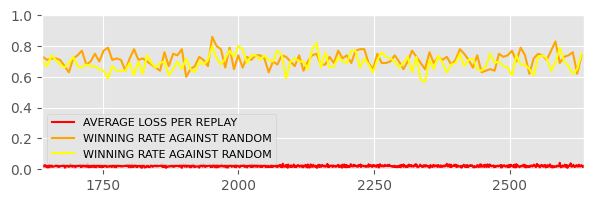

In [39]:
for i in range(6):
    C.multiple_records(A_REINFORCEMENT, A_REINFORCEMENT, total_records = 10000)
    A_REINFORCEMENT.multiple_replay(batch_size=128, total_epochs = 128, echo_option = 'EACH_EPOCH | 2', auto_save = False, performance_evaluation_circle = 8)

In [41]:
A_REINFORCEMENT.inspect_memory(2, only_terminated=True)

[PROGRESS] AGENT MEMORY LOAD: 47.06985987722874 %
[SAMPLE1]-------------------------------------------
Dropped Checker: [-1, -1]
          X          
          X          
          O          
 O        X          
 O        X          
 O        X        O 
ACTION: 3
REWARD: -1
TERMINATED: True

[SAMPLE2]-------------------------------------------
Dropped Checker: [-1, -1]
          X          
          X          
          X          
          O          
 O        X  O       
 O        X  O  O    
ACTION: 3
REWARD: -1
TERMINATED: True



In [42]:
A_REINFORCEMENT.save("../MODEL/CONNEXT_X_RESNET_C7R6.pth")